**FLO wishes to determine a roadmap for its marketing and sales department. To come up with a mid-term plan,**

**the firm needs potential values of existing customers forecasted.**

### ***Variables***
**master_id** = Unique customer id

**order_channel** = Which platform used for shopping (Android, ios, Desktop, Mobile)

**last_order_channel** = Platform used for the last shopping activity

**first_order_date** = First order date of the customer

**last_order_date** = Last order date of the customer

**last_order_date_online** = Last online order date of the customer

**last_order_date_offline** = Last offline order date of the customer

**order_num_total_ever_online**= Number of unique online orders customer have made

**order_num_total_ever_offline** = Number of unique offline orders customer have made

**customer_value_total_ever_offline** = Amount of money paid by customer for offline orders

**customer_value_total_ever_online** = Amount of money paid by customer for online orders

**interested_in_categories_12** = Categories in which customer has shopped from for the last 12 months

In [1]:
#Required Libraries and Packages
import pandas as pd
!pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
import seaborn as sns

In [2]:
#Reading the data from flo_data_20k.csv
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",500)
pd.set_option("display.float_format",lambda x:"%.3f"%x)
df_=pd.read_csv(r"C:\Users\ONUR\flo_data_20k.csv")
df=df_.copy()

In [3]:
df.head(3)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]"


In [4]:
df.shape

(19945, 12)

In [5]:
df.isnull().sum()

master_id                            0
order_channel                        0
last_order_channel                   0
first_order_date                     0
last_order_date                      0
last_order_date_online               0
last_order_date_offline              0
order_num_total_ever_online          0
order_num_total_ever_offline         0
customer_value_total_ever_offline    0
customer_value_total_ever_online     0
interested_in_categories_12          0
dtype: int64

## 1-Data Preparation

In [6]:
def outlier_threshold(dataframe,variable):
    # normally quantile values for quartile1 and quartile 3 should have been 0.75
    # and 0.25 but the tutor knows this problem beforhand and he is well aware that if
    # normal values are applied to this problem there will be a huge loss of precious data.
    quartile1= dataframe[variable].quantile(0.01)
    quartile3= dataframe[variable].quantile(0.99)
    interquantile_range=quartile3-quartile1
    up_limit=quartile3 + 1.5* interquantile_range
    low_limit=quartile3 - 1.5* interquantile_range
    return low_limit , up_limit

In [7]:
def replace_with_threshold(dataframe,variable):
    low_limit,up_limit=outlier_threshold(dataframe,variable)
    # Since we don't want frequency values with decimals, round function is used.
    dataframe.loc[dataframe[variable]<low_limit,variable]=low_limit.round()
    dataframe.loc[dataframe[variable]>up_limit,variable]=up_limit.round()

In [8]:
#Let's examine the values in columns to see if they have values needed to be replaced.
df.describe([0.01,0.99]).T
# As can be seen below maximum values for each nunerical column is way bigger than the rest.
# This creates an outlier problem which damages the reliability of the data
# We need to fix this problem by replacing outliers with limit on the side which they are located(way too big or small)

,count,mean,std,min,1%,50%,99%,max
order_num_total_ever_online,19945.000,3.111,4.226,1.000,1.000,2.000,20.000,200.000
order_num_total_ever_offline,19945.000,1.914,2.063,1.000,1.000,1.000,7.000,109.000
customer_value_total_ever_offline,19945.000,253.923,301.533,10.000,19.990,179.980,1219.947,18119.140
customer_value_total_ever_online,19945.000,497.322,832.602,12.990,39.990,286.460,3143.810,45220.130


In [9]:
num_cols=[column for column in df.columns if str(df[column].dtype) in ["int64","float64"]]
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online']

In [10]:
# We will use two functions defined above (outlier_threshold and replace_with_threshold)
for column in num_cols:
    replace_with_threshold(df,column)
#Let's check again to see whether outliers have been replaced or not
df.describe([0.01,0.99]).T
# Outliers have been replaced.

,count,mean,std,min,1%,50%,99%,max
order_num_total_ever_online,19945.000,3.092,3.810,1.000,1.000,2.000,20.000,48.000
order_num_total_ever_offline,19945.000,1.886,1.435,1.000,1.000,1.000,7.000,16.000
customer_value_total_ever_offline,19945.000,251.921,251.024,10.000,19.990,179.980,1219.947,3020.000
customer_value_total_ever_online,19945.000,489.706,632.610,12.990,39.990,286.460,3143.810,7800.000


In [11]:
# Two new columns will be created to represent the sum of order_num and customer_value.
# These new two variables will represent omnichanel(offline+online) order_num and customer_value
df["customer_value_total_ever_omnichannel"]=df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["order_num_total_ever_omnichannel"]=df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df.head(4)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,customer_value_total_ever_omnichannel,order_num_total_ever_omnichannel
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.000,1.000,139.990,799.380,[KADIN],939.370,5.000
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.000,2.000,159.970,1853.580,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.550,21.000
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.000,2.000,189.970,395.350,"[ERKEK, KADIN]",585.320,5.000
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.000,1.000,39.990,81.980,"[AKTIFCOCUK, COCUK]",121.970,2.000


In [12]:
df.dtypes
# Columns with string "date" in it carries a date value but are datatype object. This needs to be fixed.
# All columns containing date string in it will be transformed to datatype datetime

master_id                                 object
order_channel                             object
last_order_channel                        object
first_order_date                          object
last_order_date                           object
last_order_date_online                    object
last_order_date_offline                   object
order_num_total_ever_online              float64
order_num_total_ever_offline             float64
customer_value_total_ever_offline        float64
customer_value_total_ever_online         float64
interested_in_categories_12               object
customer_value_total_ever_omnichannel    float64
order_num_total_ever_omnichannel         float64
dtype: object

In [21]:
date_columns=[date_col for date_col in df.columns if "date" in date_col]
df[date_columns]=df[date_columns].apply(lambda x: pd.to_datetime(x,infer_datetime_format=True))
df.dtypes

master_id                                         object
order_channel                                     object
last_order_channel                                object
first_order_date                          datetime64[ns]
last_order_date                           datetime64[ns]
last_order_date_online                    datetime64[ns]
last_order_date_offline                   datetime64[ns]
order_num_total_ever_online                      float64
order_num_total_ever_offline                     float64
customer_value_total_ever_offline                float64
customer_value_total_ever_online                 float64
interested_in_categories_12                       object
customer_value_total_ever_omnichannel            float64
order_num_total_ever_omnichannel                 float64
recency                                  timedelta64[ns]
dtype: object

## 2-Creating CLTV DataFrame

In [14]:
last_purchase_of_all=df["last_order_date"].max()
last_purchase_of_all

Timestamp('2021-05-30 00:00:00')

In [15]:
# Firstly, we need to determine an analyse date for computation
# Let's say that analyse date will be 2 days later than the last purchase date
analyse_date= last_purchase_of_all + pd.to_timedelta(2, unit='D') 
analyse_date

Timestamp('2021-06-01 00:00:00')

In [16]:
# We will create a new dataframe from df.
# Variables are listed below

In [17]:
list(df.columns)

['master_id',
 'order_channel',
 'last_order_channel',
 'first_order_date',
 'last_order_date',
 'last_order_date_online',
 'last_order_date_offline',
 'order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online',
 'interested_in_categories_12',
 'customer_value_total_ever_omnichannel',
 'order_num_total_ever_omnichannel']

In [27]:
# I have created a variable for recency(special to customer) value of cltv
# Then I have transformed this variable from timedelta64 to int64 datatype.
df["recency"]=df["last_order_date"]-df["first_order_date"]
df["recency"]=df["recency"].apply(lambda x: x.days)
df.dtypes

master_id                                        object
order_channel                                    object
last_order_channel                               object
first_order_date                         datetime64[ns]
last_order_date                          datetime64[ns]
last_order_date_online                   datetime64[ns]
last_order_date_offline                  datetime64[ns]
order_num_total_ever_online                     float64
order_num_total_ever_offline                    float64
customer_value_total_ever_offline               float64
customer_value_total_ever_online                float64
interested_in_categories_12                      object
customer_value_total_ever_omnichannel           float64
order_num_total_ever_omnichannel                float64
recency                                           int64
dtype: object

#### Varibles for CLTV DataFrame
* **frequency(x): number purchases a customer has made**
* **recency(tx): Time difference between customer's first and last purchase**
* **T (Tenure): Time difference between customer's first purchase and analyse data (Basically customer life)**
* **monetary: Average revenue per purchase**
> Groupby by master_id will be applied to dataframe df.

In [40]:
df.nunique()

master_id                                19945
order_channel                                4
last_order_channel                           5
first_order_date                          2465
last_order_date                            366
last_order_date_online                    1743
last_order_date_offline                    738
order_num_total_ever_online                 46
order_num_total_ever_offline                16
customer_value_total_ever_offline         6081
customer_value_total_ever_online         11280
interested_in_categories_12                 32
customer_value_total_ever_omnichannel    16276
order_num_total_ever_omnichannel            51
recency                                   2398
dtype: int64

In [44]:
df.groupby("master_id").agg({"first_order_date": lambda first_order_date: first_order_date})

,first_order_date
master_id,
00016786-2f5a-11ea-bb80-000d3a38a36f,2019-11-19
00034aaa-a838-11e9-a2fc-000d3a38a36f,2015-11-09
000be838-85df-11ea-a90b-000d3a38a36f,2020-04-16
000c1fe2-a8b7-11ea-8479-000d3a38a36f,2020-06-07
000f5e3e-9dde-11ea-80cd-000d3a38a36f,2020-07-13
...,...
fff1db94-afd9-11ea-b736-000d3a38a36f,2019-04-12
fff4736a-60a4-11ea-8dd8-000d3a38a36f,2020-05-03
fffacd34-ae14-11e9-a2fc-000d3a38a36f,2018-10-14


In [53]:
cltv_df=df.groupby("master_id").agg({"order_num_total_ever_omnichannel": lambda frequency: frequency,
                                    "recency": lambda recency:recency,
                                    "first_order_date": lambda first_order_date: (analyse_date-first_order_date.min()).days,
                                    "customer_value_total_ever_omnichannel": lambda value: value})

In [55]:
#frequency(x): number purchases a customer has made
#recency(tx): Time difference between customer's first and last purchase (in weeks)
#T (Tenure): Time difference between customer's first purchase and analyse data (Basically customer life) (in weeks)
#monetary: Average revenue per purchase

cltv_df.columns=["frequency","recency","T","monetary"]
cltv_df.head()

,frequency,recency,T,monetary
master_id,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,5.000,550,560,776.070
00034aaa-a838-11e9-a2fc-000d3a38a36f,3.000,1733,2031,269.470
000be838-85df-11ea-a90b-000d3a38a36f,4.000,198,411,722.690
000c1fe2-a8b7-11ea-8479-000d3a38a36f,7.000,332,359,874.160
000f5e3e-9dde-11ea-80cd-000d3a38a36f,7.000,303,323,1620.330


In [58]:
# The values we found are in days for recency and T(Tenure). We need to transform them to weekly unit.
# Also monetary value represents the sum of money spent for all purchases. 
#We need to divide this number by the number of purchases to find average money per purchase.
cltv_df["T"]=cltv_df["T"] / 7
cltv_df["recency"]=cltv_df["recency"] / 7
cltv_df["monetary"]= cltv_df["monetary"]/cltv_df["frequency"]
cltv_df.columns=["frequency","recency_cltv_weekly","T_weekly","monetary_cltv_avg"]
cltv_df.head()

,frequency,recency_cltv_weekly,T_weekly,monetary_cltv_avg
master_id,,,,
00016786-2f5a-11ea-bb80-000d3a38a36f,5.000,11.224,11.429,31.043
00034aaa-a838-11e9-a2fc-000d3a38a36f,3.000,35.367,41.449,29.941
000be838-85df-11ea-a90b-000d3a38a36f,4.000,4.041,8.388,45.168
000c1fe2-a8b7-11ea-8479-000d3a38a36f,7.000,6.776,7.327,17.840
000f5e3e-9dde-11ea-80cd-000d3a38a36f,7.000,6.184,6.592,33.068


## 4- Installation of BG/NBD and GammaGamma Models to calculate CLTV values

In [71]:
# What's BG/NBD Model?
## This model uses parameters such as frequency, recency, and T(Tenure).
## By using parameters it forecasts the expected number of purchases in a given time period ( which will be determined by the user).

#Install BG/NBD model
bgf=BetaGeoFitter(penalizer_coef=0.001)
# Fit the model
bgf.fit(cltv_df["frequency"],
       cltv_df["recency_cltv_weekly"],
       cltv_df["T_weekly"])

<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 10.88, b: 0.00, r: 3.66>

In [72]:
# Forecasting number of expected purchases within 3 months for each customer and assigning that as a variable into cltv_df
cltv_df["exp_sales_3_month"]=bgf.conditional_expected_number_of_purchases_up_to_time(4*3,
                                                                                              cltv_df["frequency"],
                                                                                              cltv_df["recency_cltv_weekly"],
                                                                                              cltv_df["T_weekly"])
# Forecasting number of expected purchases within 6 months for each customer and assigning that as a variable into cltv_df
cltv_df["exp_sales_6_month"]=bgf.conditional_expected_number_of_purchases_up_to_time(4*6,
                                                                                              cltv_df["frequency"],
                                                                                              cltv_df["recency_cltv_weekly"],
                                                                                              cltv_df["T_weekly"])

In [73]:
cltv_df.head().sort_values("exp_sales_6_month",ascending=False)

,frequency,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month
master_id,,,,,,
000f5e3e-9dde-11ea-80cd-000d3a38a36f,7.000,6.184,6.592,33.068,7.323,14.646
000c1fe2-a8b7-11ea-8479-000d3a38a36f,7.000,6.776,7.327,17.840,7.028,14.055
000be838-85df-11ea-a90b-000d3a38a36f,4.000,4.041,8.388,45.168,4.772,9.545
00016786-2f5a-11ea-bb80-000d3a38a36f,5.000,11.224,11.429,31.043,4.660,9.320
00034aaa-a838-11e9-a2fc-000d3a38a36f,3.000,35.367,41.449,29.941,1.528,3.056


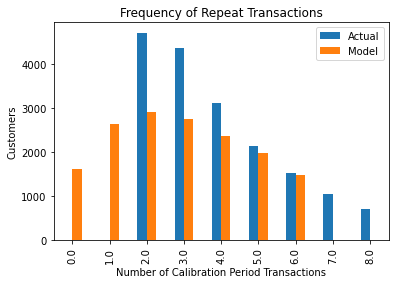

In [74]:
plot_period_transactions(bgf)
plt.show()

In [79]:
# What's Gamma Gamma Model? What does it do?
## It is used to estimate the average monetary value of customer transactions.
## It requires two 
# Installing Gamma Gamma Model
ggf= GammaGammaFitter(penalizer_coef=0.001)
# Fitting the model to cltv_df
ggf.fit(cltv_df["frequency"],
       cltv_df["monetary_cltv_avg"])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 6.57, q: 1.64, v: 6.08>

In [81]:
cltv_df.columns

Index(['frequency', 'recency_cltv_weekly', 'T_weekly', 'monetary_cltv_avg',
       'exp_sales_3_month', 'exp_sales_6_month'],
      dtype='object')

In [88]:
# Predicting expected average value of a customer by using this function
# Creating a new dataframe for keeping master_id and customer life time value.
cltv=ggf.customer_lifetime_value(bgf,
                           cltv_df["frequency"],
                            cltv_df["recency_cltv_weekly"],
                            cltv_df["T_weekly"],
                            cltv_df["monetary_cltv_avg"],
                            time=6,
                            discount_rate=0.01,
                            freq="W")
cltv=cltv.reset_index()
cltv.head()

,master_id,clv
0,00016786-2f5a-11ea-bb80-000d3a38a36f,309.413
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,99.281
2,000be838-85df-11ea-a90b-000d3a38a36f,456.449
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,272.118
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,514.355


In [95]:
# Now we will merge cltv_df and cltv on master_id column. This final dataframe will be called cltv_final
cltv_final=cltv_df.merge(cltv,how="left",on="master_id")
cltv_final.head()
## Customer lifetime value is represented as "clv" in this dataframe

,master_id,frequency,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,clv
0,00016786-2f5a-11ea-bb80-000d3a38a36f,5.000,11.224,11.429,31.043,4.660,9.320,309.413
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,3.000,35.367,41.449,29.941,1.528,3.056,99.281
2,000be838-85df-11ea-a90b-000d3a38a36f,4.000,4.041,8.388,45.168,4.772,9.545,456.449
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,7.000,6.776,7.327,17.840,7.028,14.055,272.118
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,7.000,6.184,6.592,33.068,7.323,14.646,514.355


In [96]:
# Observing first 20 customers with the highest 20 customer lifetime value
cltv_final.sort_values(by="clv",ascending=False).head(20)

,master_id,frequency,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,clv
5603,47a642fe-975b-11eb-8c2a-000d3a38a36f,4.000,0.408,1.122,350.450,7.661,15.321,5523.550
10446,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,2.000,1.184,1.347,431.345,5.557,11.115,4830.457
18740,f02473b0-43c3-11eb-806e-000d3a38a36f,2.000,2.469,3.306,417.938,4.790,9.580,4034.921
273,031b2954-6d28-11eb-99c4-000d3a38a36f,3.000,2.122,2.224,247.862,6.101,12.202,3098.565
18861,f1f89712-84e5-11eb-8a3c-000d3a38a36f,2.000,1.041,1.612,261.225,5.439,10.879,2876.294
16383,d2e74a36-3228-11eb-860c-000d3a38a36f,3.000,0.163,3.755,250.190,5.463,10.926,2800.386
7062,5a351e90-b984-11eb-a757-000d3a38a36f,2.000,0.000,0.245,225.993,6.108,12.216,2799.163
13579,ae4ce104-dbd4-11ea-8757-000d3a38a36f,3.000,0.531,6.000,281.449,4.737,9.473,2728.913
4603,3a27b334-dff4-11ea-acaa-000d3a38a36f,3.000,5.714,5.878,279.019,4.771,9.542,2725.288
4230,35bb1806-c133-11eb-8ef5-000d3a38a36f,2.000,6.082,6.122,334.988,3.997,7.993,2703.274


## 4-Segmentation of Customers Based on CLTV 

In [97]:
# 4 customer segment will be created in terms of Customer Lifetime Value.
# These groups will be ["C","B","A","S"], S consisting of customers with the highest CLTV.
cltv_final["segment"]=pd.qcut(cltv_final["clv"],4,labels=["C","B","A","S"])
# Creating a new variable called segment in cltv_final to represent the class of each customer
cltv_final.head()

,master_id,frequency,recency_cltv_weekly,T_weekly,monetary_cltv_avg,exp_sales_3_month,exp_sales_6_month,clv,segment
0,00016786-2f5a-11ea-bb80-000d3a38a36f,5.000,11.224,11.429,31.043,4.660,9.320,309.413,A
1,00034aaa-a838-11e9-a2fc-000d3a38a36f,3.000,35.367,41.449,29.941,1.528,3.056,99.281,C
2,000be838-85df-11ea-a90b-000d3a38a36f,4.000,4.041,8.388,45.168,4.772,9.545,456.449,S
3,000c1fe2-a8b7-11ea-8479-000d3a38a36f,7.000,6.776,7.327,17.840,7.028,14.055,272.118,B
4,000f5e3e-9dde-11ea-80cd-000d3a38a36f,7.000,6.184,6.592,33.068,7.323,14.646,514.355,S


In [111]:
#Let's check the descriptive statisctics of segments
cltv_final.groupby("segment").agg(["mean","max","min","count","sum"])

frequency                              recency_cltv_weekly         \
             mean    max   min count       sum                mean    max   
segment                                                                     
C           7.899 57.000 2.000  4987 39392.000              24.888 61.918   
B           5.137 52.000 2.000  4986 25613.000              12.858 58.306   
A           3.961 31.000 2.000  4986 19750.000               9.931 46.714   
S           2.915 19.000 2.000  4986 14534.000               6.757 36.878   

                               T_weekly                                \
          min count        sum     mean    max   min count        sum   
segment                                                                 
C       0.143  4987 124115.980   27.828 62.449 4.776  4987 138777.388   
B       0.000  4986  64111.041   15.564 58.449 0.510  4986  77600.612   
A       0.000  4986  49516.837   12.684 52.388 0.286  4986  63240.020   
S       0.000  4986  33689.061    9.335 43.898 0.102  4986  46544.939   

        monetary_cltv_avg                                 exp_sales_3_month  \
                     mean     max    min count        sum              mean   
segment                                                                       
C                  17.673  74.215  1.718  4987  88133.819             3.863   
B                  28.672 118.547  3.197  4986 142959.142             4.175   
A                  44.225 171.420  5.700  4986 220506.565             4.021   
S                  86.234 431.345 15.286  4986 429962.141             4.100   

                                     exp_sales_6_month                     \
           max   min count       sum              mean    max   min count   
segment                                                                     
C       20.846 1.045  4987 19265.225             7.726 41.693 2.090  4987   
B       32.593 1.057  4986 20815.650             8.350 65.186 2.114  4986   
A       23.618 1.134  4986 20049.105             8.042 47.235 2.268  4986   
S       19.465 1.241  4986 20443.319             8.200 38.930 2.481  4986   

                      clv                                     
              sum    mean      max     min count         sum  
segment                                                       
C       38530.450 122.377  178.163  19.497  4987  610296.298  
B       41631.299 224.978  274.721 178.188  4986 1121738.755  
A       40098.210 342.233  428.117 274.734  4986 1706376.135  
S       40886.638 691.648 5523.550 428.122  4986 3448558.800

## Action Plans Based on the Inferences made

> GROUP S
>> * Group S is responsible for more than half of value created within next 6 months. This group needs to be encouraged more to do shopping.
>> * Also it seems that customers in this segment are rather new compared to other segments. An incentive such as bring your friend and win a coupon can be offered to this group.

> GROUP C
>> * Looking at their clv share which is nearly %25 percent,Group C customers are well suited to rise through customer segments but there is one major drawback: money spent per visit.
>> * Segment C has high frequency numbers indicating that they shop frequently but not in big amounts. Discount coupons can be offered but these coupons won't be given randomly.
>> * The logic behind will be: The more you shop the more you get discount. This will encourage the Segment C and increase their "clv".